In [1]:
# Bibliotecas gerais
import pandas as pd
import numpy as np
from collections import Counter

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Pré-processamento
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

# Modelos
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

# Métricas
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Processamento de texto
import nltk
from nltk.corpus import stopwords


In [2]:
# Suprimindo os warnings para melhorar a visualização do notebook
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('indicum_dataset.csv')

# Faça uma análise exploratória dos dados (EDA), demonstrando as principais características entre as variáveis e apresentando algumas hipóteses de negócio relacionadas. Seja criativo!


In [4]:
df.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


In [5]:
df.shape

(48894, 16)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             48894 non-null  int64  
 1   nome                           48878 non-null  object 
 2   host_id                        48894 non-null  int64  
 3   host_name                      48873 non-null  object 
 4   bairro_group                   48894 non-null  object 
 5   bairro                         48894 non-null  object 
 6   latitude                       48894 non-null  float64
 7   longitude                      48894 non-null  float64
 8   room_type                      48894 non-null  object 
 9   price                          48894 non-null  int64  
 10  minimo_noites                  48894 non-null  int64  
 11  numero_de_reviews              48894 non-null  int64  
 12  ultima_review                  38842 non-null 

In [7]:
df.describe()

,id,host_id,latitude,longitude,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
count,4.889400e+04,4.889400e+04,48894.000000,48894.000000,48894.000000,48894.000000,48894.000000,38842.000000,48894.000000,48894.000000
mean,1.901753e+07,6.762139e+07,40.728951,-73.952169,152.720763,7.030085,23.274758,1.373251,7.144005,112.776169
std,1.098288e+07,7.861118e+07,0.054529,0.046157,240.156625,20.510741,44.550991,1.680453,32.952855,131.618692
min,2.595000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.472371e+06,7.822737e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967743e+07,3.079553e+07,40.723075,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915225e+07,1.074344e+08,40.763117,-73.936273,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [8]:
df.isnull().sum()

id                                   0
nome                                16
host_id                              0
host_name                           21
bairro_group                         0
bairro                               0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimo_noites                        0
numero_de_reviews                    0
ultima_review                    10052
reviews_por_mes                  10052
calculado_host_listings_count        0
disponibilidade_365                  0
dtype: int64

#### As colunas "nome" e "host_name" possuem pouquíssimos valores nulos, 16 e 21, respectivamente. Por ser tratar de colunas mais descritivas, e não impactarem tanto no treinamento do modelo, preenchi os registros vazios pelo nome "Desconhecido"

In [9]:
df['nome'].fillna('Desconhecido', inplace=True)
df['host_name'].fillna('Desconhecido', inplace=True)
df['reviews_por_mes'] = df['reviews_por_mes'].fillna(0)
df['ultima_review'] = df['ultima_review'].fillna(0)

##### As colunas "reviews_por_mes" e "ultima_review" estão vazias para anúncios que ainda não foram avaliadas, portanto preenchi com 0

In [10]:
df.isnull().sum()

id                               0
nome                             0
host_id                          0
host_name                        0
bairro_group                     0
bairro                           0
latitude                         0
longitude                        0
room_type                        0
price                            0
minimo_noites                    0
numero_de_reviews                0
ultima_review                    0
reviews_por_mes                  0
calculado_host_listings_count    0
disponibilidade_365              0
dtype: int64

In [11]:
# Valores únicos em cada variável
valores_unicos = []
for i in df.columns[0:17].tolist():
    print(i, ':', len(df[i].astype(str).value_counts()))
    valores_unicos.append(len(df[i].astype(str).value_counts()))


id : 48894
nome : 47905
host_id : 37457
host_name : 11453
bairro_group : 5
bairro : 221
latitude : 19048
longitude : 14718
room_type : 3
price : 674
minimo_noites : 109
numero_de_reviews : 394
ultima_review : 1765
reviews_por_mes : 938
calculado_host_listings_count : 47
disponibilidade_365 : 366


In [12]:
df.groupby(['bairro_group']).size()

bairro_group
Bronx             1091
Brooklyn         20103
Manhattan        21661
Queens            5666
Staten Island      373
dtype: int64

In [13]:
df.groupby(['bairro']).size()

bairro
Allerton            42
Arden Heights        4
Arrochar            21
Arverne             77
Astoria            900
                  ... 
Windsor Terrace    157
Woodhaven           88
Woodlawn            11
Woodrow              1
Woodside           235
Length: 221, dtype: int64

<Axes: title={'center': 'Quantidade de casas por grupo de bairros'}, xlabel='bairro_group'>

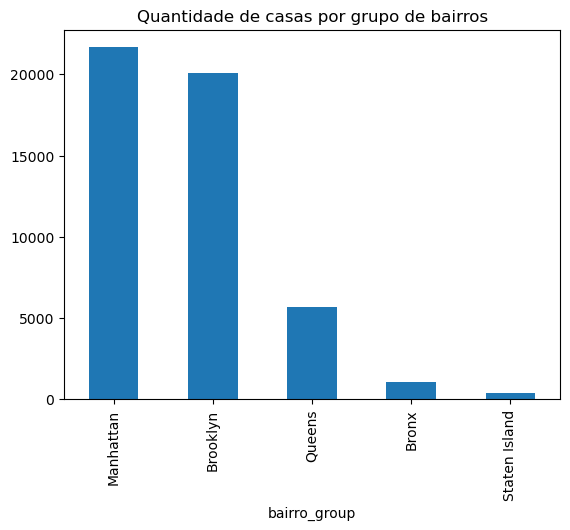

In [14]:
df.bairro_group.value_counts().plot(kind='bar', title='Quantidade de casas por grupo de bairros')

In [15]:
df.groupby(['room_type']).size()

room_type
Entire home/apt    25409
Private room       22325
Shared room         1160
dtype: int64

<Axes: title={'center': 'Quantidade de casas por tipo de quarto'}, xlabel='room_type'>

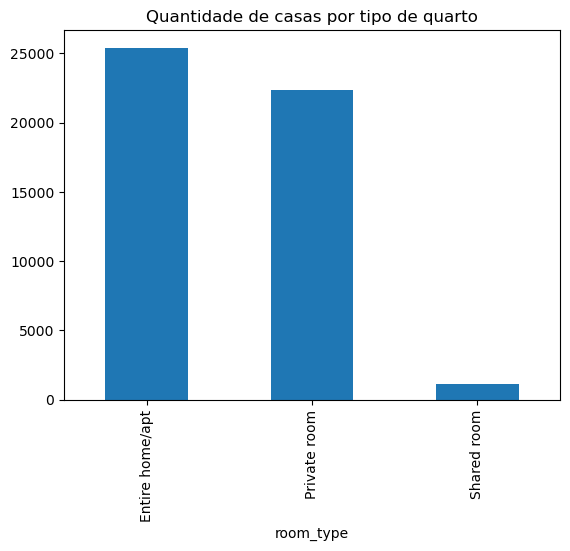

In [16]:
df.room_type.value_counts().plot(kind='bar', title='Quantidade de casas por tipo de quarto')

In [17]:
media_por_bairros = df.groupby('bairro_group')['price'].mean()

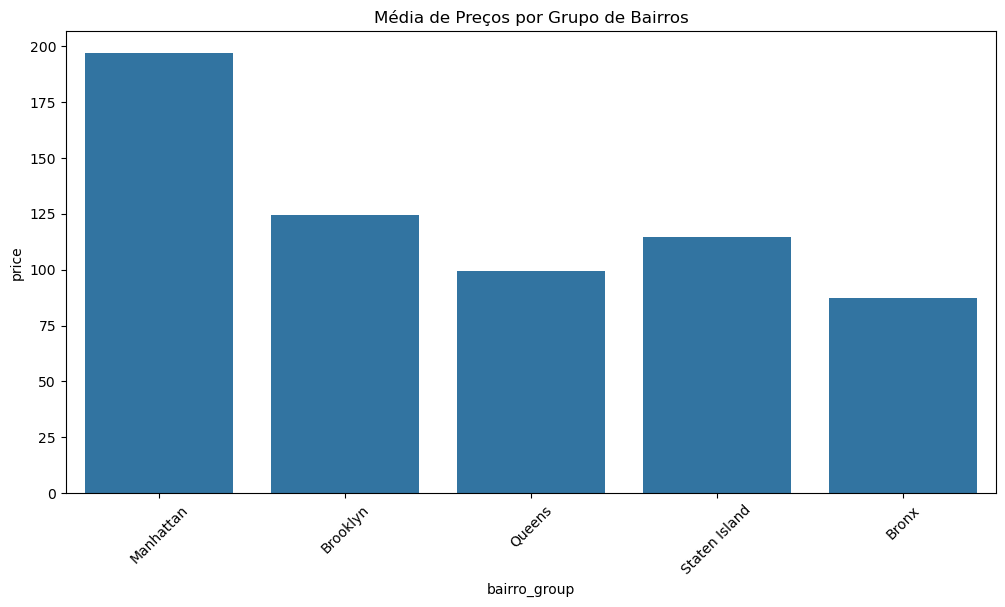

In [18]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='bairro_group', y='price', estimator=np.mean, ci=None)
plt.title('Média de Preços por Grupo de Bairros')
plt.xticks(rotation=45)
plt.show()

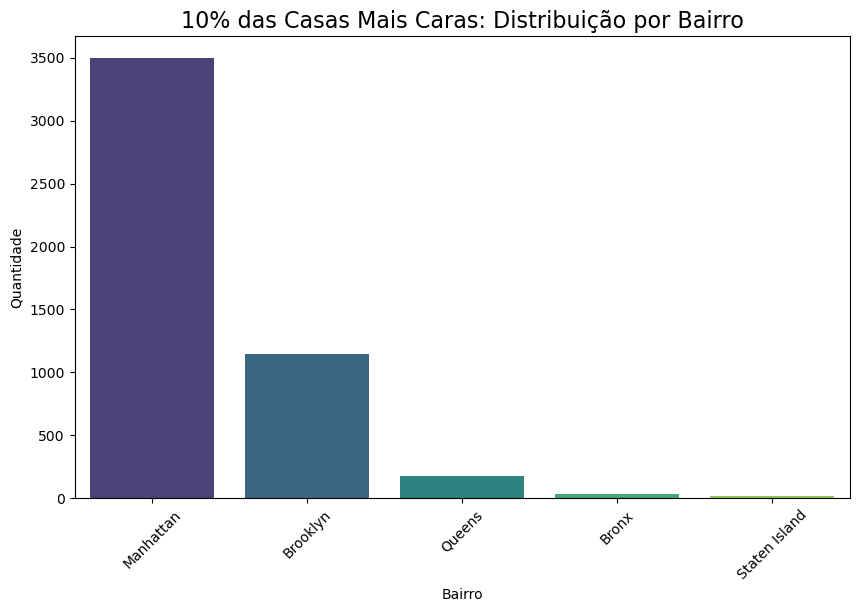

In [19]:
# Calcular o percentil 90
percentil_90 = df['price'].quantile(0.90)

# Filtrar as casas pertencentes ao percentil 90+
casas_mais_caras = df[df['price'] > percentil_90]

# Contar as casas por bairro no percentil 90+
contagem_casas_caras = casas_mais_caras['bairro_group'].value_counts()

# Criar um DataFrame para visualização
resultado = contagem_casas_caras.reset_index()
resultado.columns = ['bairro_group', 'quantidade']

# Visualizar os bairros com mais casas caras
plt.figure(figsize=(10, 6))
sns.barplot(data=resultado, x='bairro_group', y='quantidade', palette='viridis')
plt.title('10% das Casas Mais Caras: Distribuição por Bairro', fontsize=16)
plt.xlabel('Bairro')
plt.ylabel('Quantidade')
plt.xticks(rotation=45)
plt.show()

    bairro_group       media  mediana  minimo  maximo  desvio_padrao  \
0          Bronx   87.496792     65.0       0    2500     106.709349   
1       Brooklyn  124.381983     90.0       0   10000     186.878105   
2      Manhattan  196.875814    150.0       0   10000     291.383183   
3         Queens   99.517649     75.0      10   10000     167.102155   
4  Staten Island  114.812332     75.0      13    5000     277.620403   

      variancia  amplitude    iqr  
0  11386.885081       2500   54.0  
1  34923.426214      10000   90.0  
2  84904.159185      10000  125.0  
3  27923.130227       9990   60.0  
4  77073.088342       4987   60.0  


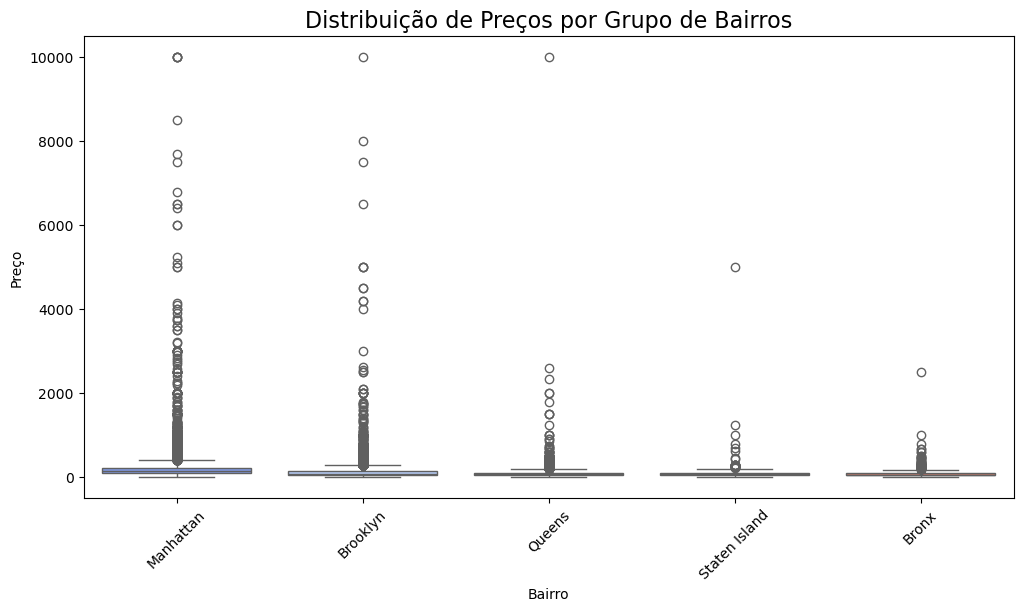

In [20]:
# Agrupar os dados por bairro e calcular medidas de posição e dispersão
estatisticas = df.groupby('bairro_group')['price'].agg(
    media='mean',
    mediana='median',
    minimo='min',
    maximo='max',
    desvio_padrao='std',
    variancia='var',
    amplitude=lambda x: x.max() - x.min(),
    iqr=lambda x: x.quantile(0.75) - x.quantile(0.25)
).reset_index()

# Exibir as estatísticas
print(estatisticas)

# Visualizar a dispersão por bairro com um boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='bairro_group', y='price', palette='coolwarm')
plt.title('Distribuição de Preços por Grupo de Bairros', fontsize=16)
plt.xlabel('Bairro')
plt.ylabel('Preço')
plt.xticks(rotation=45)
plt.show()


#### O bairro do Bronx é onde existe a maior homogeniedade entre os valores da casa, o menor desvio padrão implica em dizer que os preços estão mais próximos da média, tendo menos outliers no grupo de bairros. Enquanto isso, Manhattan possui um desvio padrão muito alto, grande parte das casas pertencentes aos 10% mais caros estão na região

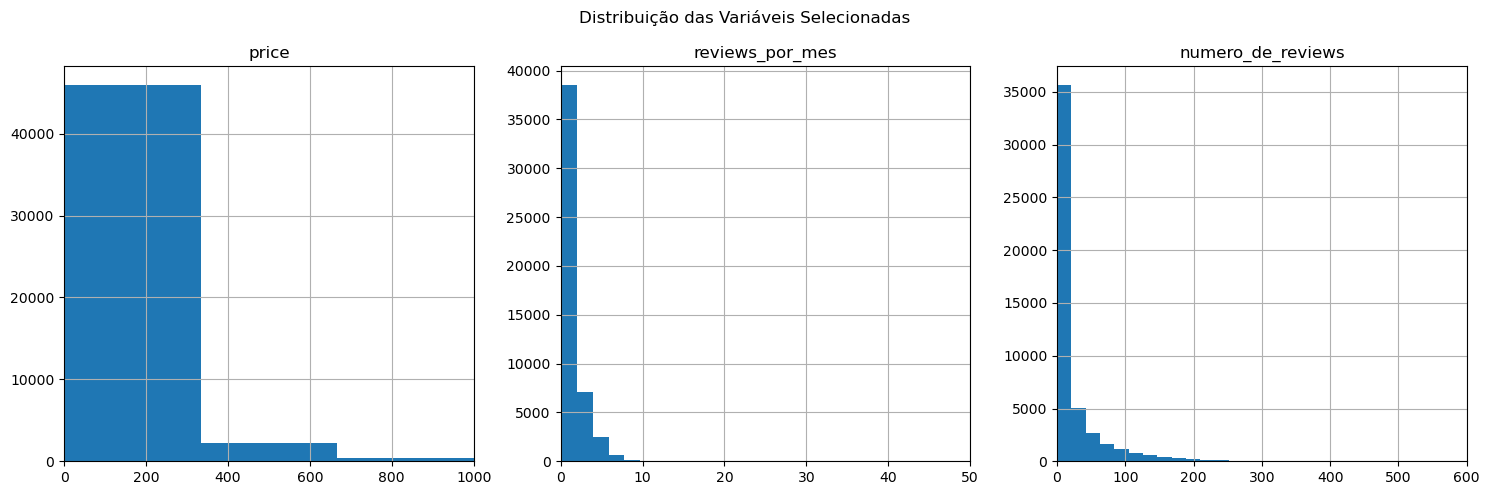

In [21]:
# Selecionando as colunas de interesse
columns_of_interest = ['price', 'reviews_por_mes', 'numero_de_reviews']

# Criando histogramas
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, col in enumerate(columns_of_interest):
    df[col].hist(bins=30, ax=axes[i])
    axes[i].set_title(col)
    if col == 'price':
        axes[i].set_xlim(0, 1000)
    elif col == 'reviews_por_mes':
        axes[i].set_xlim(0, 50)
    elif col == 'numero_de_reviews':
        axes[i].set_xlim(0, 600)
plt.suptitle("Distribuição das Variáveis Selecionadas")
plt.tight_layout()
plt.show()

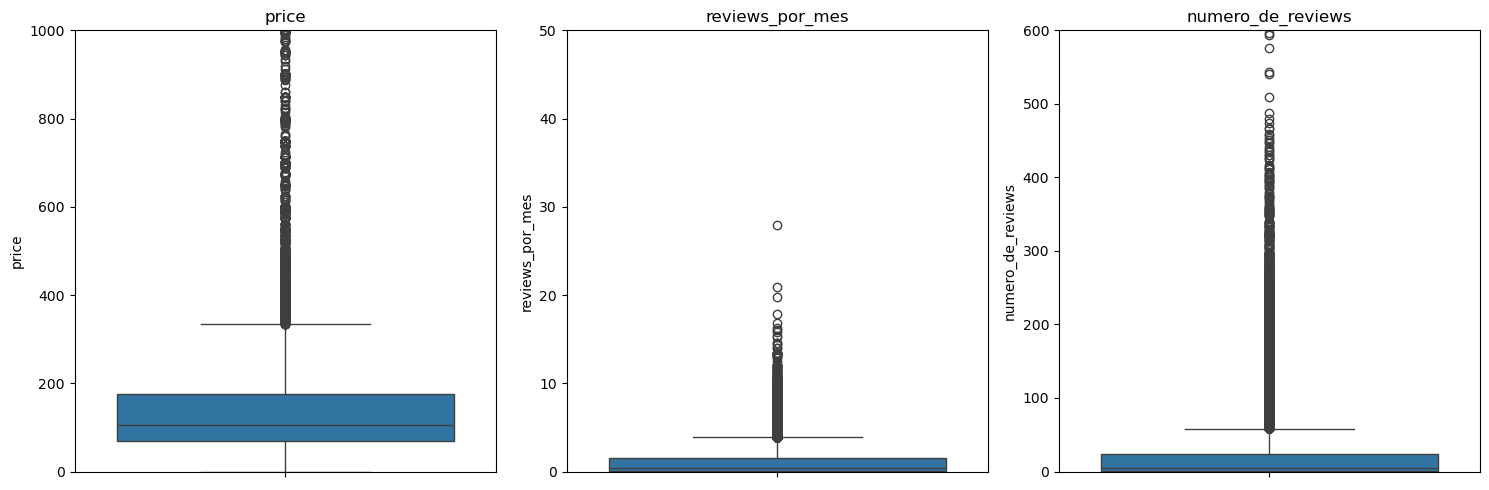

In [22]:
# Criando boxplots
plt.figure(figsize=(15, 5))
for i, col in enumerate(columns_of_interest):
    plt.subplot(1, 3, i+1)
    sns.boxplot(y=df[col])
    plt.title(col)
    if col == 'price':
        plt.ylim(0, 1000)
    elif col == 'reviews_por_mes':
        plt.ylim(0, 50)
    elif col == 'numero_de_reviews':
        plt.ylim(0, 600)
plt.tight_layout()
plt.show()

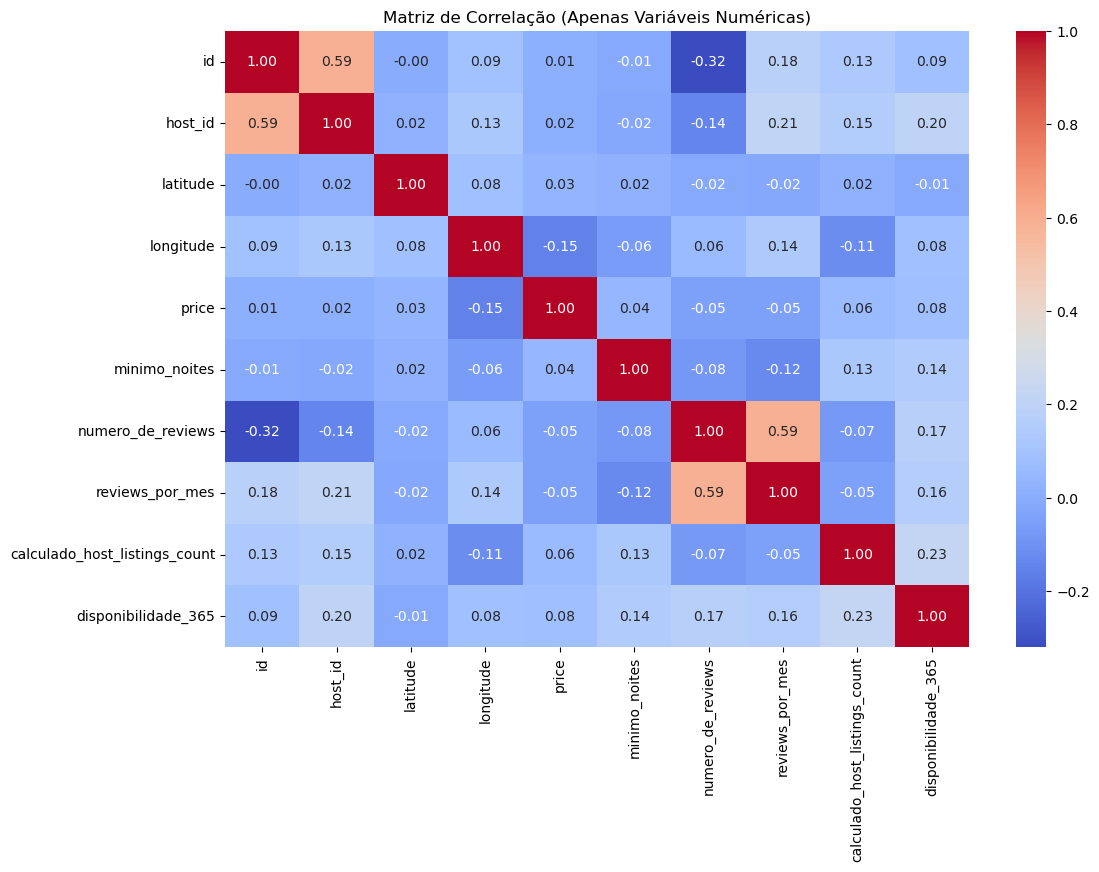

In [23]:
# Selecionar apenas colunas numéricas
df_numeric = df.select_dtypes(include=['float64', 'int64'])

# Calcular a matriz de correlação
corr = df_numeric.corr()

# Plotar o heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlação (Apenas Variáveis Numéricas)")
plt.show()

### Mapa de calor para visualizar a distribuição de preços por localidade

In [24]:
import folium
from folium.plugins import HeatMap

# Criar mapa
mapa = folium.Map(location=[40.7128, -74.0060], zoom_start=12)

# Adicionar heatmap
heat_data = [[row['latitude'], row['longitude'], row['price']] for index, row in df.iterrows()]
HeatMap(heat_data).add_to(mapa)

mapa

# 2A) Supondo que uma pessoa esteja pensando em investir em um apartamento para alugar na plataforma, onde seria mais indicada a compra?

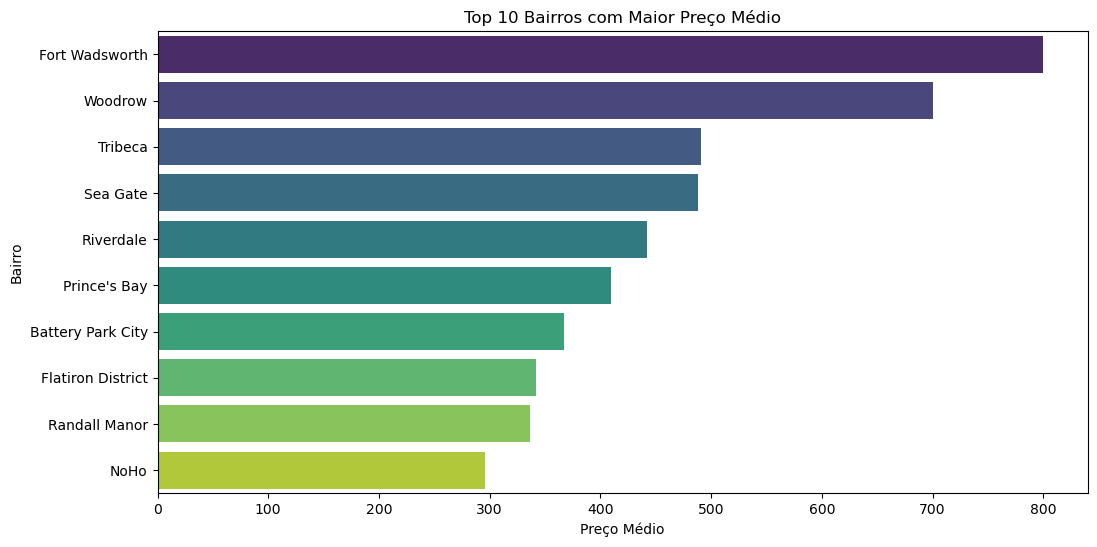

In [25]:
preco_medio_bairro = df.groupby('bairro')['price'].mean().reset_index()
preco_medio_bairro = preco_medio_bairro.sort_values(by='price', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=preco_medio_bairro.head(10), x='price', y='bairro', palette='viridis')
plt.xlabel('Preço Médio')
plt.ylabel('Bairro')
plt.title('Top 10 Bairros com Maior Preço Médio')
plt.show()


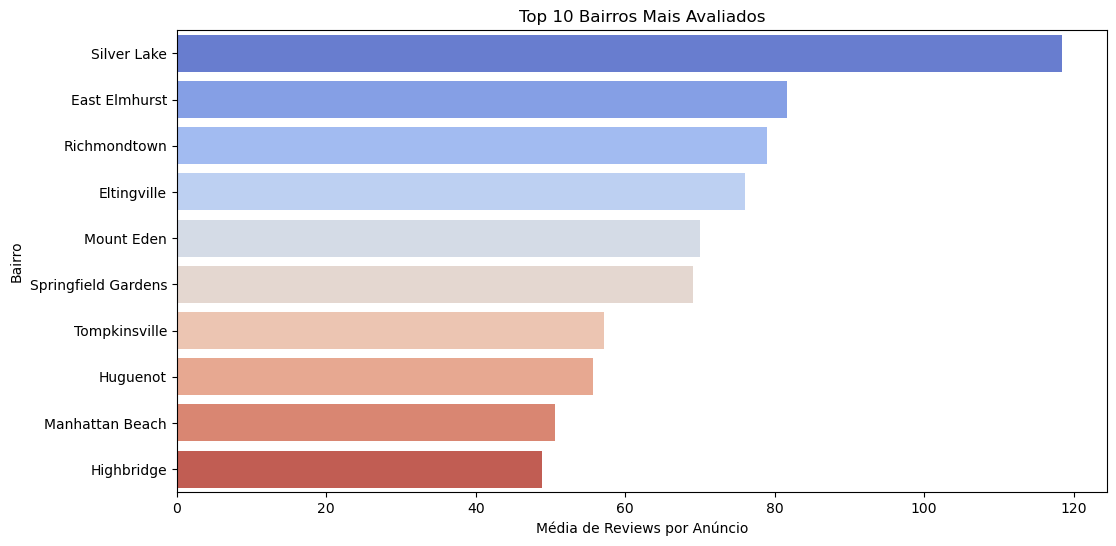

In [26]:
reviews_por_bairro = df.groupby('bairro')['numero_de_reviews'].mean().reset_index()
reviews_por_bairro = reviews_por_bairro.sort_values(by='numero_de_reviews', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=reviews_por_bairro.head(10), x='numero_de_reviews', y='bairro', palette='coolwarm')
plt.xlabel('Média de Reviews por Anúncio')
plt.ylabel('Bairro')
plt.title('Top 10 Bairros Mais Avaliados')
plt.show()


#### O bairro ideal deve ter uma boa relação entre o preço médio e a quantidade de reviews, que indica alta demanda

In [27]:
investimento_ideal = df.groupby('bairro').agg({
    'price': 'mean',
    'numero_de_reviews': 'mean'
}).reset_index()

scaler = MinMaxScaler()
investimento_ideal[['price', 'numero_de_reviews']] = scaler.fit_transform(
    investimento_ideal[['price', 'numero_de_reviews']]
)

# Evitar divisão por zero ao normalizar
investimento_ideal['numero_de_reviews'] = investimento_ideal['numero_de_reviews'].replace(0, 0.01)

# Criar uma métrica final para ranqueamento, penalizando bairros com poucos reviews
investimento_ideal['score'] = (investimento_ideal['price'] * 0.6 + 
                               investimento_ideal['numero_de_reviews'] * 0.4) * (investimento_ideal['numero_de_reviews'] + 0.1)

# Ordenar os melhores bairros para investimento
investimento_ideal = investimento_ideal.sort_values(by='score', ascending=False)

print(investimento_ideal.head(10))


                  bairro     price  numero_de_reviews     score
177          Silver Lake  0.030115           1.000000  0.459876
69           Eltingville  0.125332           0.641350  0.245935
59         East Elmhurst  0.044974           0.689109  0.238807
165         Richmondtown  0.040744           0.666667  0.223187
183  Springfield Gardens  0.062314           0.583073  0.184852
135           Mount Eden  0.014836           0.590717  0.169356
101             Huguenot  0.094331           0.469761  0.139308
167            Riverdale  0.524479           0.224779  0.131405
194        Tompkinsville  0.038340           0.482218  0.125696
120      Manhattan Beach  0.074624           0.427215  0.113699


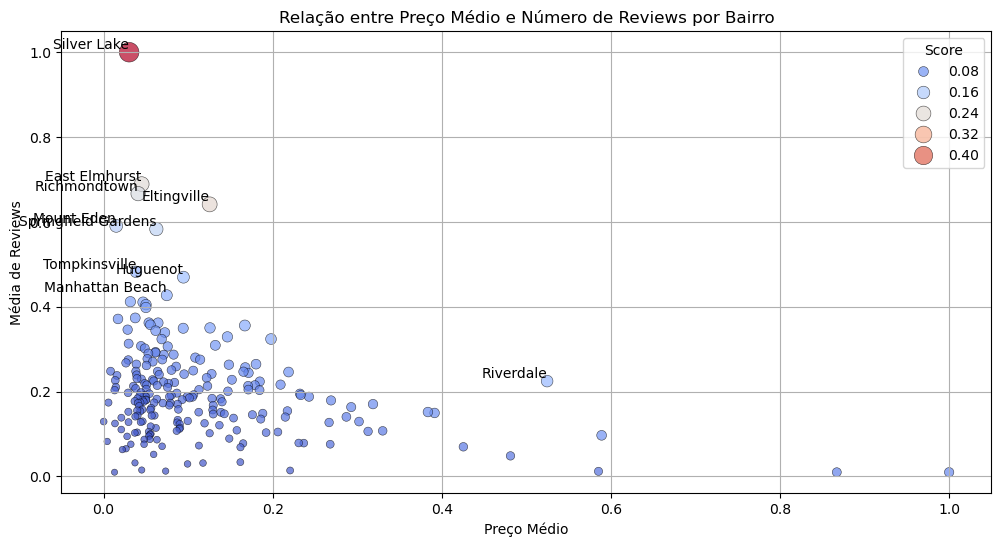

In [28]:
# Ajustar tamanho do gráfico
plt.figure(figsize=(12, 6))

# Criar gráfico de dispersão
sns.scatterplot(data=investimento_ideal, x='price', y='numero_de_reviews', hue='score', size='score', palette='coolwarm', sizes=(20, 200), edgecolor='black', alpha=0.7)

# Adicionar rótulo para os 10 bairros com maior score
for i in range(10):
    plt.text(investimento_ideal['price'].iloc[i], 
             investimento_ideal['numero_de_reviews'].iloc[i], 
             investimento_ideal['bairro'].iloc[i], 
             fontsize=10, ha='right', va='bottom')

plt.xlabel('Preço Médio')
plt.ylabel('Média de Reviews')
plt.title('Relação entre Preço Médio e Número de Reviews por Bairro')
plt.grid(True)
plt.legend(title='Score', loc='upper right')

plt.show()

##### Bairros como Fort Wadsworth e Woodrow possuem um valor médio muito assima da média, mas não possuem reviews, o que pode indicar baixíssima demanda tornando inviável o investimento. Portanto, penalizei a baixa quantidade de reviews

##### Tendo como base a relação entre preço e demanda, Silver Lake seria o melhor bairro para investir

# 2B) O número mínimo de noites e a disponibilidade ao longo do ano interferem no preço?

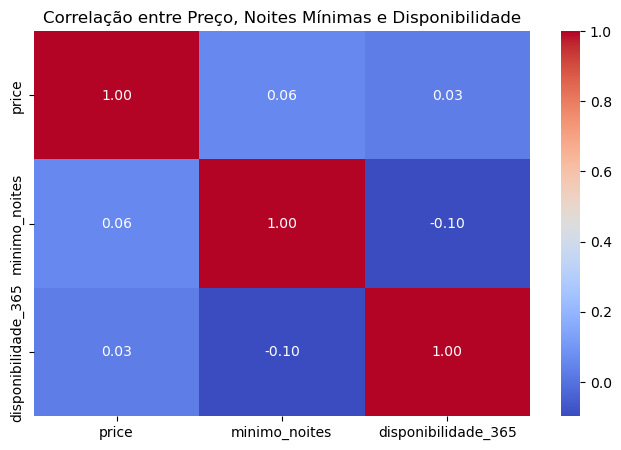

In [29]:
# Função para remover outliers com base no IQR
def remover_outliers(df, coluna):
    Q1 = df[coluna].quantile(0.25)
    Q3 = df[coluna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    return df[(df[coluna] >= limite_inferior) & (df[coluna] <= limite_superior)]

# Remover outliers das colunas relevantes
df = remover_outliers(df, 'price')
df = remover_outliers(df, 'minimo_noites')
df = remover_outliers(df, 'disponibilidade_365')

# Calcular a correlação
correlacoes = df[['price', 'minimo_noites', 'disponibilidade_365']].corr()

# Exibir heatmap da correlação
plt.figure(figsize=(8, 5))
sns.heatmap(correlacoes, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlação entre Preço, Noites Mínimas e Disponibilidade")
plt.show()


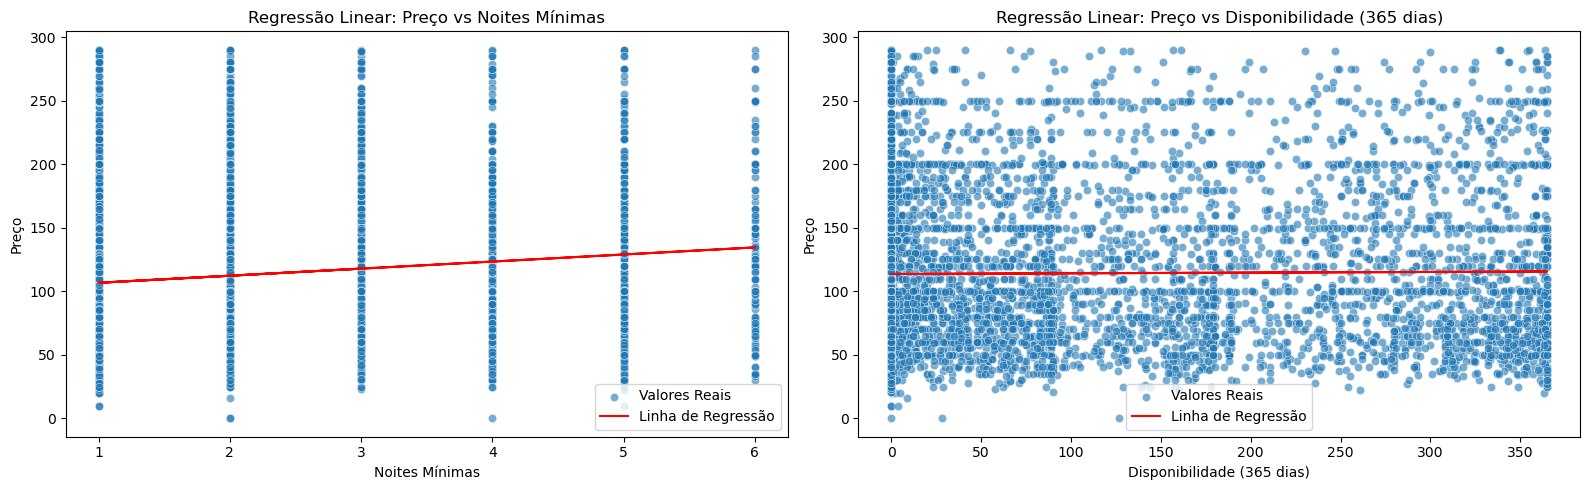

In [30]:
df = remover_outliers(df, 'price')
df = remover_outliers(df, 'minimo_noites')
df = remover_outliers(df, 'disponibilidade_365')

# Variáveis dependentes e independentes para o primeiro gráfico
X1 = df[['minimo_noites']]
y1 = df['price']

# Dividir os dados em treino e teste para o primeiro gráfico
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

# Criar o modelo de regressão linear
modelo1 = LinearRegression()

# Treinar o modelo
modelo1.fit(X1_train, y1_train)

# Fazer previsões no conjunto de teste
y1_pred = modelo1.predict(X1_test)

# Variáveis dependentes e independentes para o segundo gráfico
X2 = df[['disponibilidade_365']]
y2 = df['price']

# Dividir os dados em treino e teste para o segundo gráfico
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

# Criar o modelo de regressão linear
modelo2 = LinearRegression()

# Treinar o modelo
modelo2.fit(X2_train, y2_train)

# Fazer previsões no conjunto de teste
y2_pred = modelo2.predict(X2_test)

# Visualizar os resultados
plt.figure(figsize=(16, 5))

# Gráfico 1: Preço vs Noites Mínimas
plt.subplot(1, 2, 1)
sns.scatterplot(x=X1_test.squeeze(), y=y1_test, label="Valores Reais", alpha=0.6)
plt.plot(X1_test, y1_pred, color='red', label="Linha de Regressão")
plt.title("Regressão Linear: Preço vs Noites Mínimas")
plt.xlabel("Noites Mínimas")
plt.ylabel("Preço")
plt.legend()

# Gráfico 2: Preço vs Disponibilidade (365 dias)
plt.subplot(1, 2, 2)
sns.scatterplot(x=X2_test.squeeze(), y=y2_test, label="Valores Reais", alpha=0.6)
plt.plot(X2_test, y2_pred, color='red', label="Linha de Regressão")
plt.title("Regressão Linear: Preço vs Disponibilidade (365 dias)")
plt.xlabel("Disponibilidade (365 dias)")
plt.ylabel("Preço")
plt.legend()

plt.tight_layout()
plt.show()


##### A corrleação entre noites mínimas e a disponibilidade com o preço não é significativa, ela apresenta sim uma correlação positiva mas com um coeficiente baixíssmo, o que indica pouco impacto no valor

##### Ao remover os outliers, percebi que a correlação entre o minimo de noites e o preço é sim significativa, sendo uma correlação positiva. Enquanto isso, não existe correlação significativa entre a disponibilidade e o preço

# 2C) Existe algum padrão no texto do nome do local para lugares de mais alto valor?

          palavra  frequencia
6       apartment         703
14        bedroom         633
34            apt         441
65        village         378
116        studio         366
46       spacious         343
7            east         324
56   williamsburg         288
18          heart         281
19           park         265


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\felipe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<Figure size 1000x500 with 0 Axes>

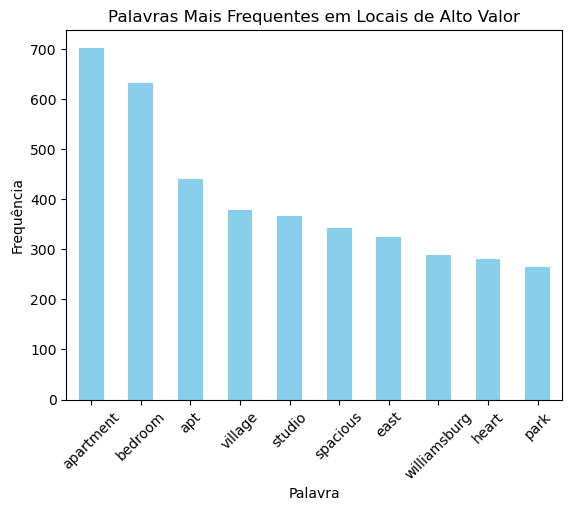

In [31]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Filtrar locais de alto valor (top 10% mais caros)
limiar_preco = df['price'].quantile(0.9)
locais_alto_valor = df[df['price'] >= limiar_preco]

# Tokenizar os nomes dos locais em palavras, removendo stopwords
locais_alto_valor['palavras'] = locais_alto_valor['nome'].str.lower().str.split()

# Remover stopwords e palavras irrelevantes
todas_palavras = [palavra for lista in locais_alto_valor['palavras'] for palavra in lista if palavra not in stop_words and palavra.isalpha()]

# Contar a frequência das palavras
frequencia_palavras = Counter(todas_palavras)

# Converter para DataFrame
df_palavras = pd.DataFrame(frequencia_palavras.items(), columns=['palavra', 'frequencia'])
df_palavras = df_palavras.sort_values(by='frequencia', ascending=False)

# Visualizar as palavras mais frequentes
print(df_palavras.head(10))

# Plotar as palavras mais frequentes
plt.figure(figsize=(10, 5))
df_palavras.head(10).plot(kind='bar', x='palavra', y='frequencia', legend=False, color='skyblue')
plt.title('Palavras Mais Frequentes em Locais de Alto Valor')
plt.xlabel('Palavra')
plt.ylabel('Frequência')
plt.xticks(rotation=45)
plt.show()


##### Separando 10% dos bairros mais caros e contando a ocorrência de palavras no nome do bairro, não obtive um bom desempenho, pois nomes muito genéricos como "Apartament" e "Bedroom" ficaram no topo, mesmo não tendo causalidade com o preço do local. Portanto, usarei Processamento de Linguagem Natural(NLP) para avalir a real contribuição de uma palavra para o valor das locações no bairro

In [32]:
# Remover valores nulos
df = df.dropna(subset=['nome', 'price'])

# Vetorização do texto dos nomes dos locais usando TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=100)  # Limita a 100 palavras mais relevantes
X_text = vectorizer.fit_transform(df['nome'])

# Variável dependente correta (preço)
y = df['price']

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=42)

# Treinar um modelo de regressão linear
modelo = LinearRegression()
modelo.fit(X_train, y_train)

# Fazer previsões
y_pred = modelo.predict(X_test)

# Avaliar o modelo
print("Erro Quadrático Médio (MSE):", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

# Identificar as palavras mais relevantes
coeficientes = modelo.coef_
palavras_importantes = pd.DataFrame({'palavra': vectorizer.get_feature_names_out(), 'coeficiente': coeficientes})
palavras_importantes = palavras_importantes.sort_values(by='coeficiente', ascending=False)

print("Palavras mais associadas a preços altos:")
print(palavras_importantes.head(10))

print("\nPalavras mais associadas a preços baixos:")
print(palavras_importantes.tail(10))


Erro Quadrático Médio (MSE): 2759.33953858397
R²: 0.2613044358957961
Palavras mais associadas a preços altos:
    palavra  coeficiente
96  village    70.640662
83     soho    66.067980
26  chelsea    65.924729
2       2br    62.451880
34   duplex    58.081626
59  midtown    56.050004
1       1br    54.172101
57   luxury    50.555658
86   square    43.579117
50  kitchen    40.923539

Palavras mais associadas a preços baixos:
     palavra  coeficiente
66      nice   -24.470880
93     train   -25.837919
74   private   -29.293820
77    queens   -29.380238
88      stuy   -29.903568
52       lga   -30.312276
49       jfk   -32.718277
23  bushwick   -44.072170
81    shared   -65.258698
80      room   -77.690555


##### Utilizanddo NLP, recebi um MSE muito alto e um coeficiente de determinação muito baixo, o que pode indicar que não existe padrão entre os locais mais caros e o nome do bairro ou incapacidade do modelo de identificar essas relações

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF para análise de texto
vectorizer = TfidfVectorizer(stop_words='english', max_features=100)
X_text = vectorizer.fit_transform(df['nome'])

# Palavras mais importantes
palavras_importantes = pd.DataFrame({'palavra': vectorizer.get_feature_names_out(), 'importancia': X_text.sum(axis=0).A1})
palavras_importantes = palavras_importantes.sort_values(by='importancia', ascending=False)
print(palavras_importantes.head(10))

      palavra  importancia
80       room  3222.601926
15    bedroom  2566.298892
74    private  2443.460076
4   apartment  2276.049074
32       cozy  1956.485377
21   brooklyn  1768.672294
5         apt  1517.362678
87     studio  1478.052951
85   spacious  1433.456389
58  manhattan  1327.288196


# 3) Explique como você faria a previsão do preço a partir dos dados. Quais variáveis e/ou suas transformações você utilizou e por quê? Qual tipo de problema estamos resolvendo (regressão, classificação)? Qual modelo melhor se aproxima dos dados e quais seus prós e contras? Qual medida de performance do modelo foi escolhida e por quê?


In [34]:
from math import radians, sin, cos, sqrt, atan2

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Raio da Terra em km
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

In [35]:
# Adicionar distâncias até pontos estratégicos
df['dist_times_square'] = df.apply(lambda row: haversine(row['latitude'], row['longitude'], 40.7589, -73.9851), axis=1)
df['dist_central_park'] = df.apply(lambda row: haversine(row['latitude'], row['longitude'], 40.785091, -73.968285), axis=1)
df['dist_empire_state'] = df.apply(lambda row: haversine(row['latitude'], row['longitude'], 40.748817, -73.985428), axis=1)
df['dist_statue_liberty'] = df.apply(lambda row: haversine(row['latitude'], row['longitude'], 40.689247, -74.044502), axis=1)
df['dist_wall_street'] = df.apply(lambda row: haversine(row['latitude'], row['longitude'], 40.706877, -74.011265), axis=1)
df['dist_brooklyn_bridge'] = df.apply(lambda row: haversine(row['latitude'], row['longitude'], 40.706086, -73.996864), axis=1)

In [36]:
# Separar features e target
X = df.drop(columns=['price', 'id', 'nome', 'host_id', 'host_name'])
y = df['price']

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pré-processamento
categorical_features = ['bairro_group', 'bairro', 'room_type']
numeric_features = [
    'latitude', 'longitude', 'minimo_noites', 'numero_de_reviews', 
    'reviews_por_mes', 'calculado_host_listings_count', 'disponibilidade_365',
    'dist_times_square', 'dist_central_park', 'dist_empire_state', 
    'dist_statue_liberty', 'dist_wall_street', 'dist_brooklyn_bridge'
]

# Verificar se todas as colunas estão presentes no DataFrame
missing_cols = set(numeric_features) - set(X.columns)
if missing_cols:
    raise ValueError(f"As seguintes colunas não foram encontradas no DataFrame: {missing_cols}")

# ColumnTransformer para pré-processamento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),  # Normaliza features numéricas
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)  # Codifica features categóricas
    ])

# Pipeline do modelo
model = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Pré-processamento
    ('regressor', RandomForestRegressor(random_state=42))  # Modelo de regressão
])

# Treinar o modelo
model.fit(X_train, y_train)

# Prever
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)

print(f"Erro absoluto médio(MAE): {mae:.2f}")

Erro absoluto médio(MAE): 29.78


# 4) Supondo um apartamento com as seguintes características, qual seria a sua sugestão de preço?

In [37]:
# Dados de entrada
input_data = {
    'id': 2595,
    'nome': 'Skylit Midtown Castle',
    'host_id': 2845,
    'host_name': 'Jennifer',
    'bairro_group': 'Manhattan',
    'bairro': 'Midtown',
    'latitude': 40.75362,
    'longitude': -73.98377,
    'room_type': 'Entire home/apt',
    'minimo_noites': 1,
    'numero_de_reviews': 45,
    'ultima_review': '2019-05-21',
    'reviews_por_mes': 0.38,
    'calculado_host_listings_count': 2,
    'disponibilidade_365': 355
}

# Criar um DataFrame com os dados de entrada
input_df = pd.DataFrame([input_data])

input_df['dist_times_square'] = input_df.apply(lambda row: haversine(row['latitude'], row['longitude'], 40.7589, -73.9851), axis=1)
input_df['dist_central_park'] = input_df.apply(lambda row: haversine(row['latitude'], row['longitude'], 40.785091, -73.968285), axis=1)
input_df['dist_empire_state'] = input_df.apply(lambda row: haversine(row['latitude'], row['longitude'], 40.748817, -73.985428), axis=1)
input_df['dist_statue_liberty'] = input_df.apply(lambda row: haversine(row['latitude'], row['longitude'], 40.689247, -74.044502), axis=1)
input_df['dist_wall_street'] = input_df.apply(lambda row: haversine(row['latitude'], row['longitude'], 40.706877, -74.011265), axis=1)
input_df['dist_brooklyn_bridge'] = input_df.apply(lambda row: haversine(row['latitude'], row['longitude'], 40.706086, -73.996864), axis=1)# Adicione as outras distâncias conforme necessário...

# Remover colunas que não serão usadas no modelo
input_df = input_df.drop(columns=['id', 'nome', 'host_id', 'host_name', 'ultima_review'])

# Fazer a previsão
predicted_price = model.predict(input_df)

# Exibir o resultado
print(f"O preço sugerido para o apartamento é: ${predicted_price[0]:.2f}")

O preço sugerido para o apartamento é: $201.23


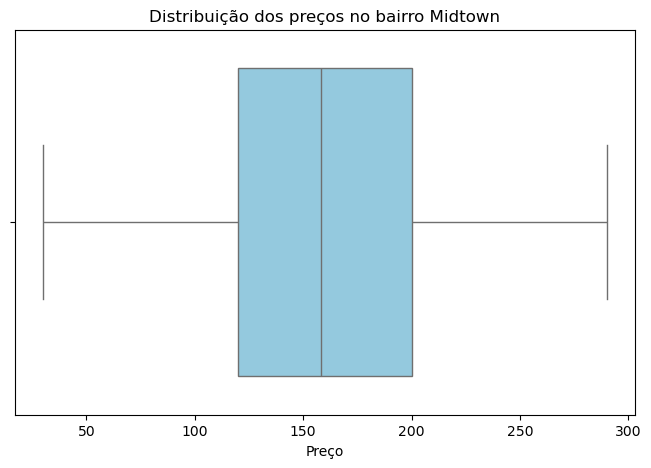

In [38]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=df[df["bairro"] == "Midtown"]["price"], color="skyblue")
plt.xlabel("Preço")
plt.title("Distribuição dos preços no bairro Midtown")
plt.show()
